# UNet Semantic Segmentation with ResNet50 Backbone

Notebook terstruktur untuk training dan evaluasi UNet + ResNet50 (atau backbone lain) dengan metric lengkap (loss, pixel accuracy, mean IoU) dan visualisasi hasil.

In [2]:
# Cell 1: Imports & setup

import os
import math
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image

import segmentation_models_pytorch as smp

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Matplotlib
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Seed untuk reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)



Device: cuda


## Path & hyperparameters

In [16]:
# Cell 2: Paths & hyperparameters

# Sesuaikan dengan struktur folder kamu
BASE_DIR      = Path(".")   # atau Path("E:/AI_Projects/Self_driving")
TRAIN_IMG_DIR = BASE_DIR / "images_train"
TRAIN_MASK_DIR= BASE_DIR / "masks_train"
TEST_IMG_DIR  = BASE_DIR / "images_test"
TEST_MASK_DIR = BASE_DIR / "masks_test"

print("Train images :", len(os.listdir(TRAIN_IMG_DIR)))
print("Train masks  :", len(os.listdir(TRAIN_MASK_DIR)))
print("Test images  :", len(os.listdir(TEST_IMG_DIR)))
print("Test masks   :", len(os.listdir(TEST_MASK_DIR)))

# Hyperparameters
num_classes   = 12             # UBAH sesuai jumlah kelas mask kamu!
batch_size    = 8
num_epochs    = 80
base_lr       = 1e-4           # base LR untuk AdamW
max_lr        = 3e-4           # max LR bila pakai OneCycle
weight_decay  = 1e-4
num_workers   = 0

print("num_classes:", num_classes)


Train images : 367
Train masks  : 367
Test images  : 101
Test masks   : 101
num_classes: 12


## Dataset + augmentasi ringan & aman

In [17]:
# Cell 3: Dataset + transforms

class SelfDrivingSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = Path(images_dir)
        self.masks_dir  = Path(masks_dir)
        self.transform  = transform

        self.images = sorted(os.listdir(self.images_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name  = self.images[idx]
        img_path  = self.images_dir / img_name
        mask_path = self.masks_dir  / img_name

        # Image RGB
        img  = np.array(Image.open(img_path).convert("RGB"))
        # Mask grayscale/indexed
        mask = np.array(Image.open(mask_path))

        if mask.ndim == 3:
            mask = mask[:, :, 0]

        img  = np.ascontiguousarray(img)
        mask = np.ascontiguousarray(mask)

        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img  = augmented["image"]   # tensor [3,H,W]
            mask = augmented["mask"]    # numpy [H,W]
        else:
            img = ToTensorV2()(image=img)["image"]

        mask = torch.as_tensor(mask, dtype=torch.long)
        return img, mask


# Augmentasi TRAIN – sengaja dibuat ringan
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),

    A.RandomBrightnessContrast(
        brightness_limit=0.05,
        contrast_limit=0.05,
        p=0.2
    ),

    A.GaussNoise(
        var_limit=(1.0, 5.0),
        p=0.1
    ),

    A.ShiftScaleRotate(
        shift_limit=0.01,
        scale_limit=0.01,
        rotate_limit=1,
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.1
    ),

    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])

# Transform TEST – tanpa augmentasi
test_transform = A.Compose([
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2()
])


## DataLoader + sanity check

In [18]:
# Cell 4: Dataloaders & sanity check

train_dataset = SelfDrivingSegDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=train_transform)
test_dataset  = SelfDrivingSegDataset(TEST_IMG_DIR,  TEST_MASK_DIR,  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

print("Train batches / epoch:", len(train_loader))
print("Test  batches / epoch:", len(test_loader))

# Cek satu sample
img_sample, mask_sample = train_dataset[0]
print("Sample image shape:", img_sample.shape)
print("Sample mask shape :", mask_sample.shape)
print("Unique mask values (sample):", torch.unique(mask_sample))


Train batches / epoch: 46
Test  batches / epoch: 13
Sample image shape: torch.Size([3, 360, 480])
Sample mask shape : torch.Size([360, 480])
Unique mask values (sample): tensor([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11])


## Model UNet + ResNet50

In [19]:
# Cell 5: Model (UNet + ResNet50 encoder)

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes
).to(device)

print(model.__class__.__name__, "with encoder:", "resnet50")



Unet with encoder: resnet50


## Loss, metrics, evaluation helpers

In [20]:
# Cell 6: Loss, metrics, utilities

# (Opsional) class weights untuk menolong kelas kecil -> boleh disesuaikan
class_weights = None
# Contoh kalau mau pakai:
# class_weights = torch.tensor([1,1,5,1,1,1,10,10,1,15,3,8], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=base_lr,
    weight_decay=weight_decay
)

# ====== OneCycleLR (optional, disarankan) ======
use_scheduler = True
if use_scheduler:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs
    )
else:
    scheduler = None


def compute_metrics_from_cm(cm):
    """
    cm: confusion matrix [num_classes, num_classes]
    """
    # IoU per class
    intersection = np.diag(cm)
    ground_truth = cm.sum(axis=1)
    predicted    = cm.sum(axis=0)
    union        = ground_truth + predicted - intersection
    iou_per_class = np.where(union > 0, intersection / union, 0.0)

    mean_iou      = iou_per_class.mean()
    pixel_acc     = intersection.sum() / cm.sum()

    return iou_per_class, mean_iou, pixel_acc


@torch.no_grad()
def evaluate(model, dataloader, num_classes, device):
    model.eval()
    all_preds   = []
    all_targets = []

    for images, masks in dataloader:
        images = images.to(device)
        masks  = masks.to(device)

        logits = model(images)              # [B,C,H,W]
        preds  = torch.argmax(logits, dim=1)  # [B,H,W]

        all_preds.append(preds.cpu().numpy().reshape(-1))
        all_targets.append(masks.cpu().numpy().reshape(-1))

    all_preds   = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    cm = confusion_matrix(all_targets, all_preds, labels=list(range(num_classes)))
    iou_per_class, mean_iou, pixel_acc = compute_metrics_from_cm(cm)

    precision    = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    recall       = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    f1_macro     = f1_score(all_targets, all_preds, average="macro", zero_division=0)
    f1_per_class = f1_score(all_targets, all_preds, average=None,
                            labels=list(range(num_classes)), zero_division=0)

    metrics = {
        "cm": cm,
        "iou_per_class": iou_per_class,
        "mean_iou": mean_iou,
        "pixel_acc": pixel_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1_macro,
        "f1_per_class": f1_per_class
    }
    return metrics


## Training loop + best model saving

In [21]:
# Cell 7: Training loop

from tqdm.auto import tqdm

history = {
    "train_loss": [],
    "val_mean_iou": [],
    "val_pixel_acc": []
}

best_val_iou = 0.0
best_model_path = "best_unet_resnet50.pth"

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")
    for images, masks in pbar:
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss   = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        if use_scheduler:
            scheduler.step()

        running_loss += loss.item() * images.size(0)
        pbar.set_postfix({"loss": f"{loss.item():.3f}"})

    epoch_loss = running_loss / len(train_dataset)
    history["train_loss"].append(epoch_loss)

    # evaluasi di test set
    val_metrics = evaluate(model, test_loader, num_classes, device)
    history["val_mean_iou"].append(val_metrics["mean_iou"])
    history["val_pixel_acc"].append(val_metrics["pixel_acc"])

    print(f"\nEpoch {epoch}/{num_epochs} - "
          f"Train loss: {epoch_loss:.4f} | "
          f"Val mIoU: {val_metrics['mean_iou']:.4f} | "
          f"Val Acc: {val_metrics['pixel_acc']:.4f}")

    # simpan model terbaik (berdasarkan mIoU)
    if val_metrics["mean_iou"] > best_val_iou:
        best_val_iou = val_metrics["mean_iou"]
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✓ Best model updated (mIoU={best_val_iou:.4f})")

print("Training selesai. Best mIoU:", best_val_iou)


Epoch 1/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 1/80 - Train loss: 2.2864 | Val mIoU: 0.1095 | Val Acc: 0.2323
  ✓ Best model updated (mIoU=0.1095)


Epoch 2/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 2/80 - Train loss: 1.9022 | Val mIoU: 0.2237 | Val Acc: 0.4673
  ✓ Best model updated (mIoU=0.2237)


Epoch 3/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 3/80 - Train loss: 1.6451 | Val mIoU: 0.3322 | Val Acc: 0.6990
  ✓ Best model updated (mIoU=0.3322)


Epoch 4/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 4/80 - Train loss: 1.4535 | Val mIoU: 0.3651 | Val Acc: 0.7867
  ✓ Best model updated (mIoU=0.3651)


Epoch 5/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 5/80 - Train loss: 1.2803 | Val mIoU: 0.3764 | Val Acc: 0.8212
  ✓ Best model updated (mIoU=0.3764)


Epoch 6/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 6/80 - Train loss: 1.1381 | Val mIoU: 0.3737 | Val Acc: 0.8221


Epoch 7/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 7/80 - Train loss: 0.9816 | Val mIoU: 0.3691 | Val Acc: 0.8312


Epoch 8/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 8/80 - Train loss: 0.8477 | Val mIoU: 0.3851 | Val Acc: 0.8441
  ✓ Best model updated (mIoU=0.3851)


Epoch 9/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 9/80 - Train loss: 0.7363 | Val mIoU: 0.3996 | Val Acc: 0.8464
  ✓ Best model updated (mIoU=0.3996)


Epoch 10/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 10/80 - Train loss: 0.6426 | Val mIoU: 0.4055 | Val Acc: 0.8646
  ✓ Best model updated (mIoU=0.4055)


Epoch 11/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 11/80 - Train loss: 0.5549 | Val mIoU: 0.4078 | Val Acc: 0.8553
  ✓ Best model updated (mIoU=0.4078)


Epoch 12/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 12/80 - Train loss: 0.4990 | Val mIoU: 0.4201 | Val Acc: 0.8729
  ✓ Best model updated (mIoU=0.4201)


Epoch 13/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 13/80 - Train loss: 0.4433 | Val mIoU: 0.4442 | Val Acc: 0.8784
  ✓ Best model updated (mIoU=0.4442)


Epoch 14/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 14/80 - Train loss: 0.3954 | Val mIoU: 0.4450 | Val Acc: 0.8729
  ✓ Best model updated (mIoU=0.4450)


Epoch 15/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 15/80 - Train loss: 0.3615 | Val mIoU: 0.4783 | Val Acc: 0.8878
  ✓ Best model updated (mIoU=0.4783)


Epoch 16/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 16/80 - Train loss: 0.3441 | Val mIoU: 0.4964 | Val Acc: 0.8906
  ✓ Best model updated (mIoU=0.4964)


Epoch 17/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 17/80 - Train loss: 0.3513 | Val mIoU: 0.4742 | Val Acc: 0.8667


Epoch 18/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 18/80 - Train loss: 0.3713 | Val mIoU: 0.4658 | Val Acc: 0.8463


Epoch 19/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 19/80 - Train loss: 0.3214 | Val mIoU: 0.5057 | Val Acc: 0.8879
  ✓ Best model updated (mIoU=0.5057)


Epoch 20/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 20/80 - Train loss: 0.3021 | Val mIoU: 0.5286 | Val Acc: 0.8985
  ✓ Best model updated (mIoU=0.5286)


Epoch 21/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 21/80 - Train loss: 0.2627 | Val mIoU: 0.5640 | Val Acc: 0.9034
  ✓ Best model updated (mIoU=0.5640)


Epoch 22/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 22/80 - Train loss: 0.2412 | Val mIoU: 0.5739 | Val Acc: 0.9059
  ✓ Best model updated (mIoU=0.5739)


Epoch 23/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 23/80 - Train loss: 0.2292 | Val mIoU: 0.5791 | Val Acc: 0.9080
  ✓ Best model updated (mIoU=0.5791)


Epoch 24/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 24/80 - Train loss: 0.2147 | Val mIoU: 0.5975 | Val Acc: 0.9106
  ✓ Best model updated (mIoU=0.5975)


Epoch 25/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 25/80 - Train loss: 0.2022 | Val mIoU: 0.5849 | Val Acc: 0.9078


Epoch 26/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 26/80 - Train loss: 0.1946 | Val mIoU: 0.5920 | Val Acc: 0.9068


Epoch 27/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 27/80 - Train loss: 0.1884 | Val mIoU: 0.6162 | Val Acc: 0.9134
  ✓ Best model updated (mIoU=0.6162)


Epoch 28/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 28/80 - Train loss: 0.1776 | Val mIoU: 0.6361 | Val Acc: 0.9137
  ✓ Best model updated (mIoU=0.6361)


Epoch 29/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 29/80 - Train loss: 0.1683 | Val mIoU: 0.6299 | Val Acc: 0.9154


Epoch 30/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 30/80 - Train loss: 0.1583 | Val mIoU: 0.6562 | Val Acc: 0.9169
  ✓ Best model updated (mIoU=0.6562)


Epoch 31/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 31/80 - Train loss: 0.1529 | Val mIoU: 0.6596 | Val Acc: 0.9222
  ✓ Best model updated (mIoU=0.6596)


Epoch 32/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 32/80 - Train loss: 0.1504 | Val mIoU: 0.6440 | Val Acc: 0.9207


Epoch 33/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 33/80 - Train loss: 0.1465 | Val mIoU: 0.6583 | Val Acc: 0.9233


Epoch 34/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 34/80 - Train loss: 0.1407 | Val mIoU: 0.6790 | Val Acc: 0.9261
  ✓ Best model updated (mIoU=0.6790)


Epoch 35/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 35/80 - Train loss: 0.1339 | Val mIoU: 0.6941 | Val Acc: 0.9292
  ✓ Best model updated (mIoU=0.6941)


Epoch 36/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 36/80 - Train loss: 0.1288 | Val mIoU: 0.6914 | Val Acc: 0.9287


Epoch 37/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 37/80 - Train loss: 0.1279 | Val mIoU: 0.6887 | Val Acc: 0.9277


Epoch 38/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 38/80 - Train loss: 0.1236 | Val mIoU: 0.6931 | Val Acc: 0.9288


Epoch 39/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 39/80 - Train loss: 0.1196 | Val mIoU: 0.6940 | Val Acc: 0.9286


Epoch 40/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 40/80 - Train loss: 0.1185 | Val mIoU: 0.6933 | Val Acc: 0.9301


Epoch 41/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 41/80 - Train loss: 0.1136 | Val mIoU: 0.6981 | Val Acc: 0.9293
  ✓ Best model updated (mIoU=0.6981)


Epoch 42/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 42/80 - Train loss: 0.1104 | Val mIoU: 0.7050 | Val Acc: 0.9315
  ✓ Best model updated (mIoU=0.7050)


Epoch 43/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 43/80 - Train loss: 0.1084 | Val mIoU: 0.6955 | Val Acc: 0.9298


Epoch 44/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 44/80 - Train loss: 0.1060 | Val mIoU: 0.7021 | Val Acc: 0.9286


Epoch 45/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 45/80 - Train loss: 0.1044 | Val mIoU: 0.6944 | Val Acc: 0.9309


Epoch 46/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 46/80 - Train loss: 0.1028 | Val mIoU: 0.6935 | Val Acc: 0.9291


Epoch 47/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 47/80 - Train loss: 0.0981 | Val mIoU: 0.7040 | Val Acc: 0.9290


Epoch 48/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 48/80 - Train loss: 0.0975 | Val mIoU: 0.7023 | Val Acc: 0.9316


Epoch 49/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 49/80 - Train loss: 0.0957 | Val mIoU: 0.7003 | Val Acc: 0.9307


Epoch 50/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 50/80 - Train loss: 0.0930 | Val mIoU: 0.7077 | Val Acc: 0.9326
  ✓ Best model updated (mIoU=0.7077)


Epoch 51/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 51/80 - Train loss: 0.0915 | Val mIoU: 0.6985 | Val Acc: 0.9300


Epoch 52/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 52/80 - Train loss: 0.0909 | Val mIoU: 0.7055 | Val Acc: 0.9315


Epoch 53/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 53/80 - Train loss: 0.0897 | Val mIoU: 0.7042 | Val Acc: 0.9301


Epoch 54/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 54/80 - Train loss: 0.0863 | Val mIoU: 0.7032 | Val Acc: 0.9304


Epoch 55/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 55/80 - Train loss: 0.0847 | Val mIoU: 0.7006 | Val Acc: 0.9292


Epoch 56/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 56/80 - Train loss: 0.0833 | Val mIoU: 0.7095 | Val Acc: 0.9319
  ✓ Best model updated (mIoU=0.7095)


Epoch 57/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 57/80 - Train loss: 0.0845 | Val mIoU: 0.7024 | Val Acc: 0.9306


Epoch 58/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 58/80 - Train loss: 0.0810 | Val mIoU: 0.7017 | Val Acc: 0.9298


Epoch 59/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 59/80 - Train loss: 0.0814 | Val mIoU: 0.7036 | Val Acc: 0.9301


Epoch 60/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 60/80 - Train loss: 0.0787 | Val mIoU: 0.7059 | Val Acc: 0.9314


Epoch 61/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 61/80 - Train loss: 0.0773 | Val mIoU: 0.7045 | Val Acc: 0.9311


Epoch 62/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 62/80 - Train loss: 0.0785 | Val mIoU: 0.7069 | Val Acc: 0.9308


Epoch 63/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 63/80 - Train loss: 0.0761 | Val mIoU: 0.7078 | Val Acc: 0.9318


Epoch 64/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 64/80 - Train loss: 0.0738 | Val mIoU: 0.7059 | Val Acc: 0.9315


Epoch 65/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 65/80 - Train loss: 0.0754 | Val mIoU: 0.7044 | Val Acc: 0.9320


Epoch 66/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 66/80 - Train loss: 0.0738 | Val mIoU: 0.7046 | Val Acc: 0.9313


Epoch 67/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 67/80 - Train loss: 0.0734 | Val mIoU: 0.7055 | Val Acc: 0.9314


Epoch 68/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 68/80 - Train loss: 0.0731 | Val mIoU: 0.7049 | Val Acc: 0.9314


Epoch 69/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 69/80 - Train loss: 0.0731 | Val mIoU: 0.7046 | Val Acc: 0.9307


Epoch 70/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 70/80 - Train loss: 0.0715 | Val mIoU: 0.7049 | Val Acc: 0.9306


Epoch 71/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 71/80 - Train loss: 0.0709 | Val mIoU: 0.7049 | Val Acc: 0.9313


Epoch 72/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 72/80 - Train loss: 0.0713 | Val mIoU: 0.7059 | Val Acc: 0.9312


Epoch 73/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 73/80 - Train loss: 0.0704 | Val mIoU: 0.7052 | Val Acc: 0.9311


Epoch 74/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 74/80 - Train loss: 0.0702 | Val mIoU: 0.7049 | Val Acc: 0.9311


Epoch 75/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 75/80 - Train loss: 0.0701 | Val mIoU: 0.7044 | Val Acc: 0.9313


Epoch 76/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 76/80 - Train loss: 0.0699 | Val mIoU: 0.7064 | Val Acc: 0.9309


Epoch 77/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 77/80 - Train loss: 0.0700 | Val mIoU: 0.7055 | Val Acc: 0.9312


Epoch 78/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 78/80 - Train loss: 0.0688 | Val mIoU: 0.7055 | Val Acc: 0.9311


Epoch 79/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 79/80 - Train loss: 0.0702 | Val mIoU: 0.7053 | Val Acc: 0.9306


Epoch 80/80:   0%|          | 0/46 [00:00<?, ?it/s]


Epoch 80/80 - Train loss: 0.0684 | Val mIoU: 0.7050 | Val Acc: 0.9311
Training selesai. Best mIoU: 0.7094566777186232


## Load best model & final evaluation

In [22]:
# Cell 8: Final evaluation (best model)

best_model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,
    in_channels=3,
    classes=num_classes
).to(device)

best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

final_metrics = evaluate(best_model, test_loader, num_classes, device)

print("=== Final Evaluation Results (Best Model) ===")
print("Pixel Accuracy :", final_metrics["pixel_acc"])
print("Mean IoU       :", final_metrics["mean_iou"])
print("Precision      :", final_metrics["precision"])
print("Recall         :", final_metrics["recall"])
print("F1-score       :", final_metrics["f1"])
print("IoU per class  :", final_metrics["iou_per_class"])


=== Final Evaluation Results (Best Model) ===
Pixel Accuracy : 0.9319072011367804
Mean IoU       : 0.7094566777186232
Precision      : 0.8086514700328272
Recall         : 0.8024982115005987
F1-score       : 0.7980205432501556
IoU per class  : [0.94230383 0.86314159 0.15051899 0.96931928 0.87791912 0.90843359
 0.61981015 0.66699007 0.86369254 0.554687   0.81041541 0.28624858]


In [23]:
## Visualisasi sample prediksi

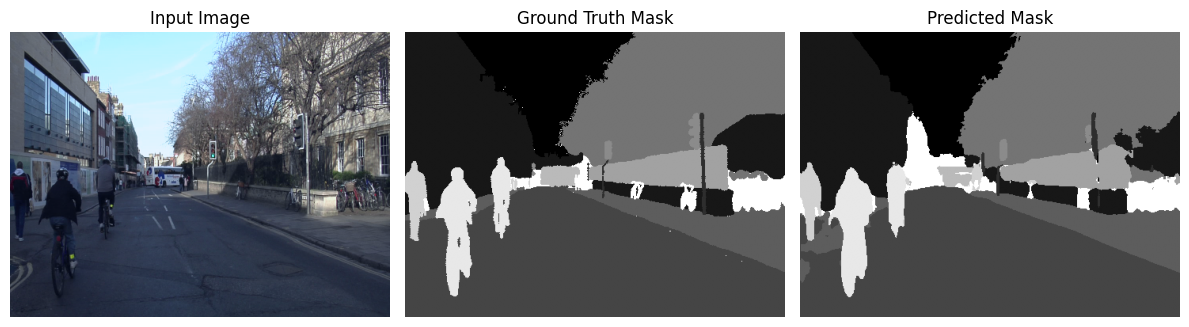

In [36]:
# Cell 9: Visualize a sample prediction

@torch.no_grad()
def visualize_sample(model, dataset, idx=0):
    model.eval()
    img, mask_true = dataset[idx]
    img_input = img.unsqueeze(0).to(device)

    logits = model(img_input)
    pred = torch.argmax(logits, dim=1)[0].cpu()

    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow(img_np)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(mask_true.cpu(), cmap="gray")
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred, cmap="gray")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_sample(best_model, test_dataset, idx=80)  # ubah index kalau mau



In [25]:
## Plot & simpan training curves

Saved training curves to results/training_progress_resnet50.png


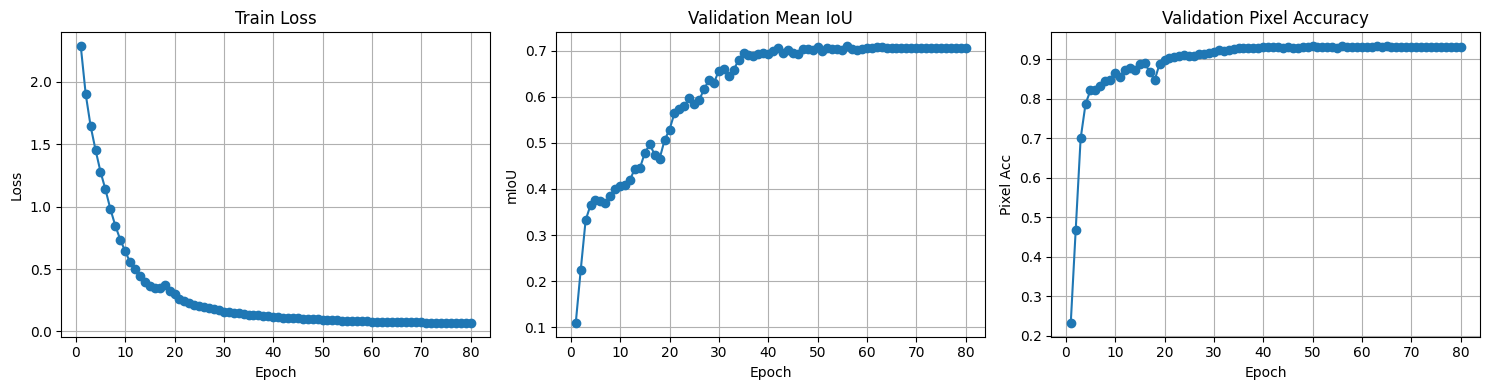

In [26]:
# Cell 10: Plot & save training curves

os.makedirs("results", exist_ok=True)

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(epochs, history["train_loss"], marker='o')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,3,2)
plt.plot(epochs, history["val_mean_iou"], marker='o')
plt.title("Validation Mean IoU")
plt.xlabel("Epoch")
plt.ylabel("mIoU")

plt.subplot(1,3,3)
plt.plot(epochs, history["val_pixel_acc"], marker='o')
plt.title("Validation Pixel Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Pixel Acc")

plt.tight_layout()
plt.savefig("results/training_progress_resnet50.png", dpi=200)
print("Saved training curves to results/training_progress_resnet50.png")
plt.show()


## Bar metrics (seperti contohmu) + confusion matrix + IoU per class

Saved metrics summary to results/metrics_summary_resnet50.png


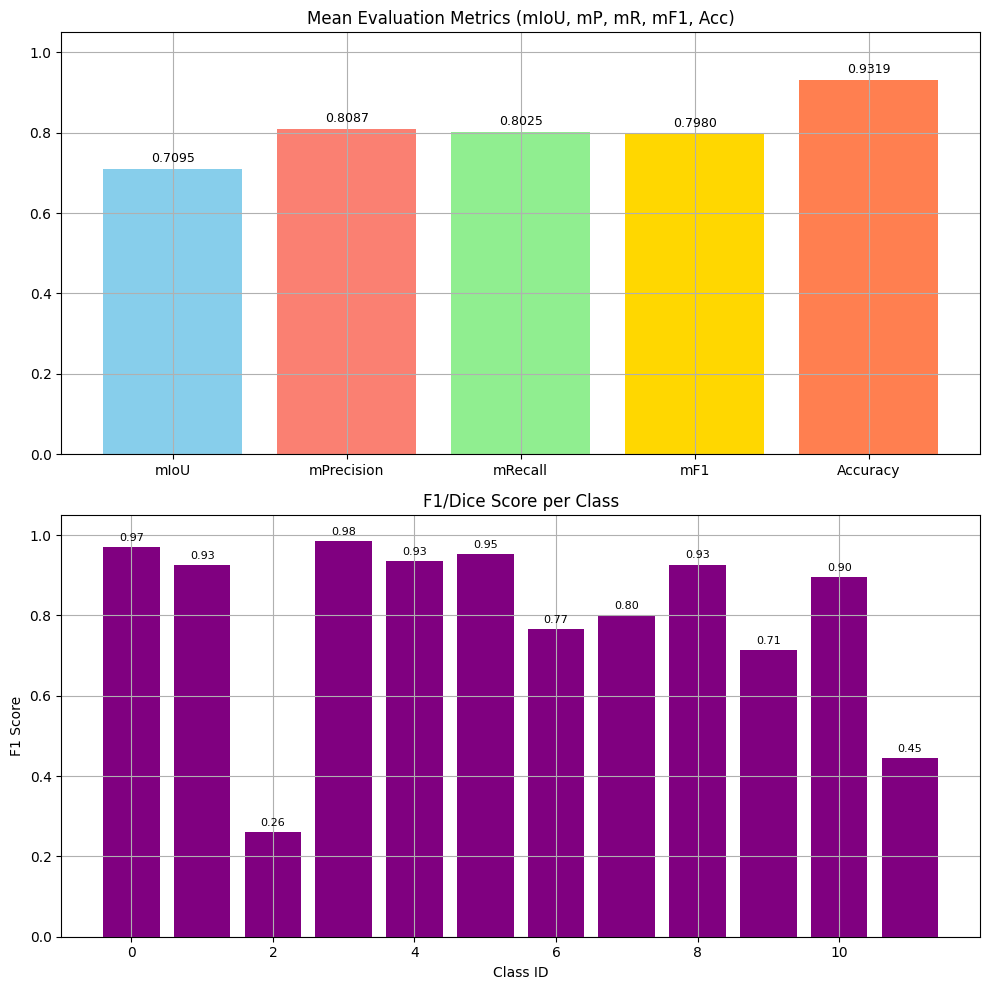

Saved confusion matrix to results/confusion_matrix_resnet50.png


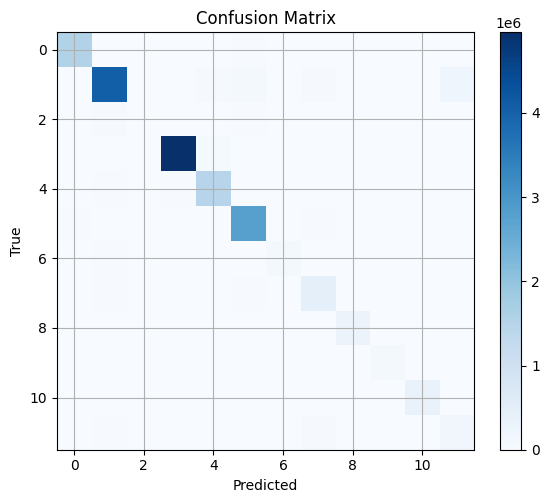

Saved IoU-per-class plot to results/iou_per_class_resnet50.png


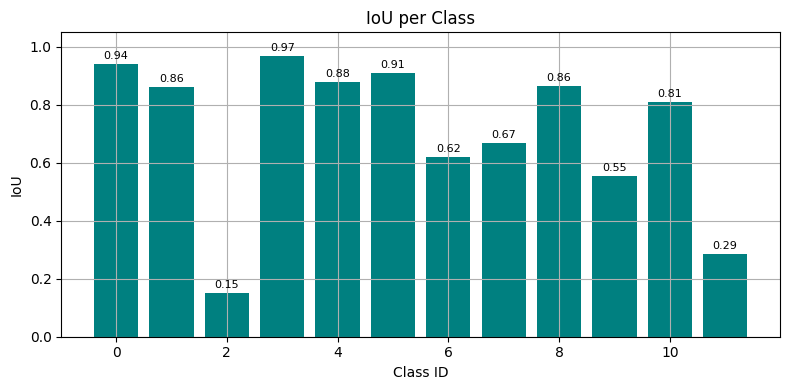

In [27]:
# Cell 11: Metrics bar charts & confusion matrix

mIoU      = final_metrics["mean_iou"]
mPrec     = final_metrics["precision"]
mRec      = final_metrics["recall"]
mF1       = final_metrics["f1"]
acc       = final_metrics["pixel_acc"]
f1_per_cls = final_metrics["f1_per_class"]
iou_per_cls = final_metrics["iou_per_class"]
cm        = final_metrics["cm"]

# ---- Figure 1: mean metrics + F1 per class ----
plt.figure(figsize=(10,10))

# Top: mean metrics
plt.subplot(2,1,1)
metric_names  = ["mIoU", "mPrecision", "mRecall", "mF1", "Accuracy"]
metric_values = [mIoU, mPrec, mRec, mF1, acc]
colors        = ["skyblue", "salmon", "lightgreen", "gold", "coral"]

bars = plt.bar(metric_names, metric_values, color=colors)
for b, v in zip(bars, metric_values):
    plt.text(b.get_x() + b.get_width()/2., v + 0.01,
             f"{v:.4f}", ha='center', va='bottom', fontsize=9)
plt.ylim(0, 1.05)
plt.title("Mean Evaluation Metrics (mIoU, mP, mR, mF1, Acc)")

# Bottom: F1 per class
plt.subplot(2,1,2)
classes = np.arange(len(f1_per_cls))
bars2 = plt.bar(classes, f1_per_cls, color="purple")
for b, v in zip(bars2, f1_per_cls):
    plt.text(b.get_x() + b.get_width()/2., v + 0.01,
             f"{v:.2f}", ha='center', va='bottom', fontsize=8)
plt.xlabel("Class ID")
plt.ylabel("F1 Score")
plt.title("F1/Dice Score per Class")
plt.ylim(0, 1.05)

plt.tight_layout()
plt.savefig("results/metrics_summary_resnet50.png", dpi=200)
print("Saved metrics summary to results/metrics_summary_resnet50.png")
plt.show()


# ---- Figure 2: Confusion matrix ----
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("results/confusion_matrix_resnet50.png", dpi=200)
print("Saved confusion matrix to results/confusion_matrix_resnet50.png")
plt.show()


# ---- Figure 3: IoU per class ----
plt.figure(figsize=(8,4))
classes = np.arange(len(iou_per_cls))
plt.bar(classes, iou_per_cls, color="teal")
for x, v in zip(classes, iou_per_cls):
    plt.text(x, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=8)
plt.xlabel("Class ID")
plt.ylabel("IoU")
plt.title("IoU per Class")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.savefig("results/iou_per_class_resnet50.png", dpi=200)
print("Saved IoU-per-class plot to results/iou_per_class_resnet50.png")
plt.show()


In [48]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ============================================
#  UNNORMALIZE (balik ke RGB normal)
# ============================================
def unnormalize(img_tensor):
    """
    img_tensor: [3,H,W] (normalized)
    return:     [H,W,3] (RGB 0-1)
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    
    img = img_tensor.cpu().permute(1,2,0).numpy()   # [H,W,3]
    img = img * std + mean                          # un-normalize
    img = np.clip(img, 0, 1)                        # valid range
    return img


# ============================================
#  COLORIZE MASK (mask -> RGB)
# ============================================
def colorize_mask(mask, class_colors):
    """
    mask: [H,W] integer class IDs
    class_colors: numpy array shape [num_classes, 3]
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for cls_id in range(len(class_colors)):
        color_mask[mask == cls_id] = class_colors[cls_id]

    return color_mask


In [49]:
def overlay_mask(image_rgb, mask, class_colors, alpha=0.45):
    """
    image_rgb : [H,W,3] float (0-1)
    mask      : [H,W] integer class mask
    class_colors: [num_classes,3] uint8 color map
    alpha     : transparansi overlay
    """
    h, w = mask.shape

    # Buat colored mask
    color_mask = colorize_mask(mask, class_colors).astype(np.float32) / 255.0

    # Resize jika tidak sama (harusnya sama)
    if color_mask.shape[:2] != image_rgb.shape[:2]:
        color_mask = cv2.resize(color_mask, (image_rgb.shape[1], image_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Overlay
    blended = image_rgb * (1 - alpha) + color_mask * alpha
    blended = np.clip(blended, 0, 1)

    return blended


In [50]:
def visualize_overlay(model, dataloader, class_colors, num_samples=3):
    model.eval()

    for i in range(num_samples):

        # ambil sample dari dataset
        img_tensor, mask_tensor = dataloader.dataset[i]
        img_input = img_tensor.unsqueeze(0).to(device)

        # --- Prediksi ---
        with torch.no_grad():
            logits = model(img_input)
            pred_mask = torch.argmax(logits, dim=1).cpu().squeeze(0).numpy()

        # --- Convert images ---
        img_vis  = unnormalize(img_tensor)                             # RGB normal
        gt_color = colorize_mask(mask_tensor.numpy(), class_colors)    # GT colored
        pr_overlay = overlay_mask(img_vis, pred_mask, class_colors)    # overlay pred

        # --- Plot ---
        plt.figure(figsize=(18,5))

        plt.subplot(1,3,1)
        plt.imshow(img_vis)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(gt_color)
        plt.title("Ground Truth Mask (Colored)")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pr_overlay)
        plt.title("Predicted Mask Overlay")
        plt.axis("off")

        plt.show()


In [51]:
def visualize_samples(model, dataloader, class_colors, num_samples=3):
    model.eval()

    for i in range(num_samples):

        # Ambil sample dari dataset (bukan dari batch)
        img_tensor, mask_tensor = dataloader.dataset[i]

        # Tambah batch dim
        img_input = img_tensor.unsqueeze(0).to(device)

        # --- PREDIKSI ---
        with torch.no_grad():
            logits = model(img_input)
            pred_mask = torch.argmax(logits, dim=1).cpu().squeeze(0).numpy()

        # --- CONVERT VISUAL ---
        img_vis  = unnormalize(img_tensor)                         # RGB input
        gt_color = colorize_mask(mask_tensor.numpy(), class_colors)
        pr_color = colorize_mask(pred_mask, class_colors)

        # --- PLOT ---
        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.imshow(img_vis)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(gt_color)
        plt.title("Ground Truth Mask (Colored)")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(pr_color)
        plt.title("Predicted Mask (Colored)")
        plt.axis("off")

        plt.show()


In [52]:
# Buat colormap otomatis
import random
num_classes = 12

random.seed(42)
class_colors = np.array([
    [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    for _ in range(num_classes)
], dtype=np.uint8)

class_colors[0] = [0,0,0]   # class background tetap hitam


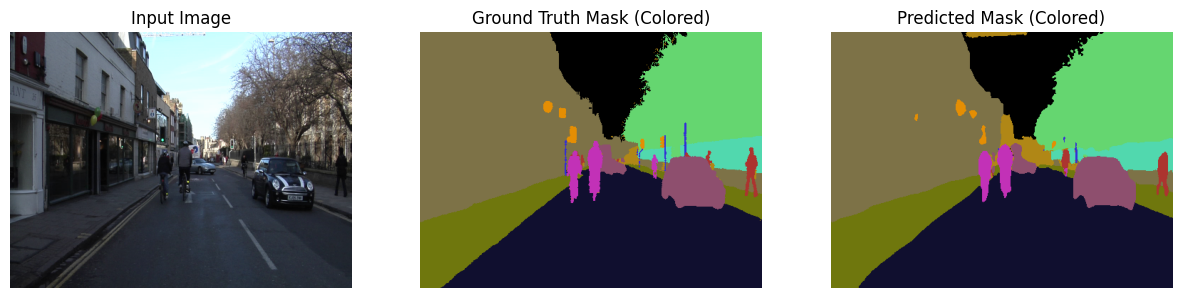

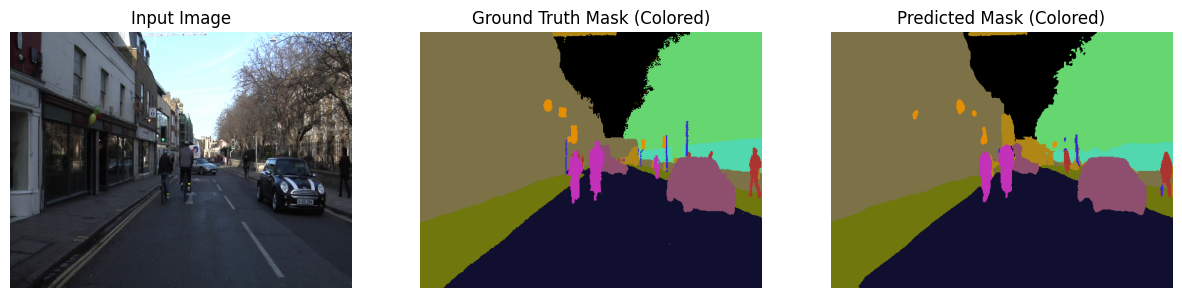

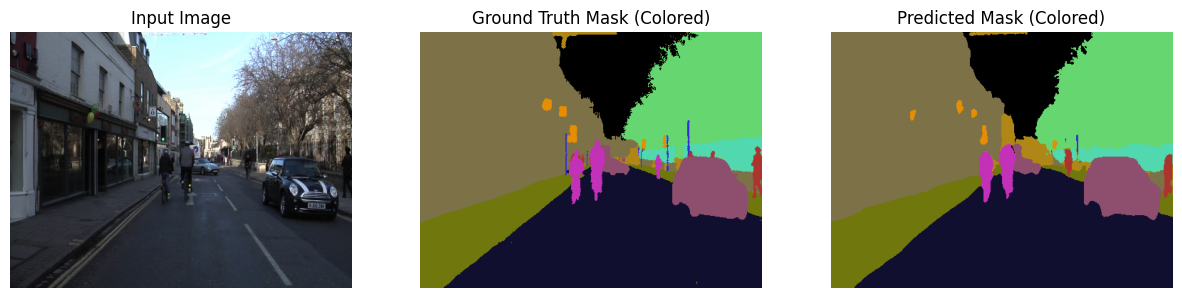

In [53]:
visualize_samples(best_model, test_loader, class_colors, num_samples=3)


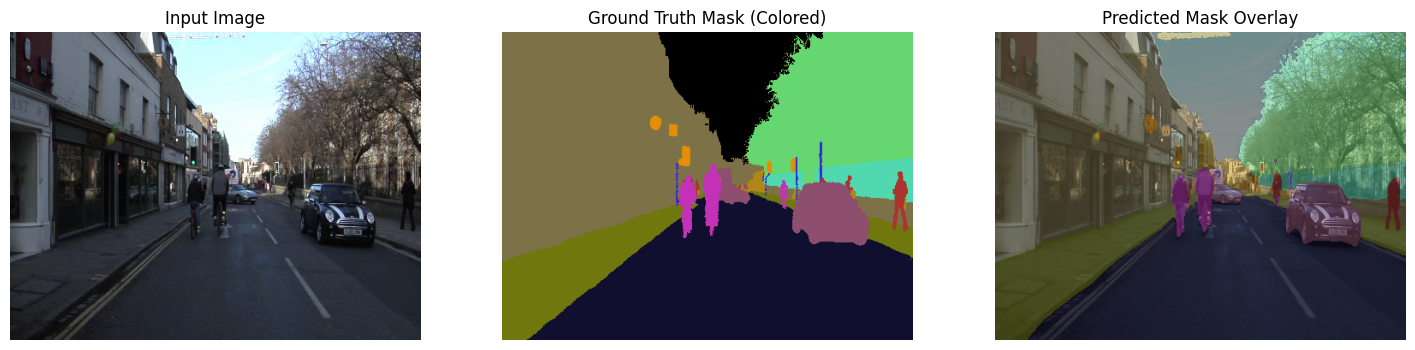

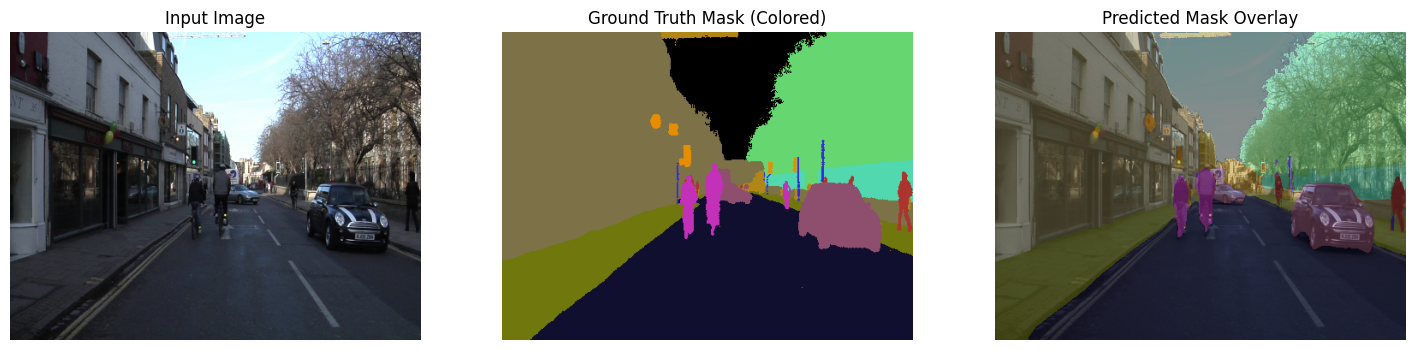

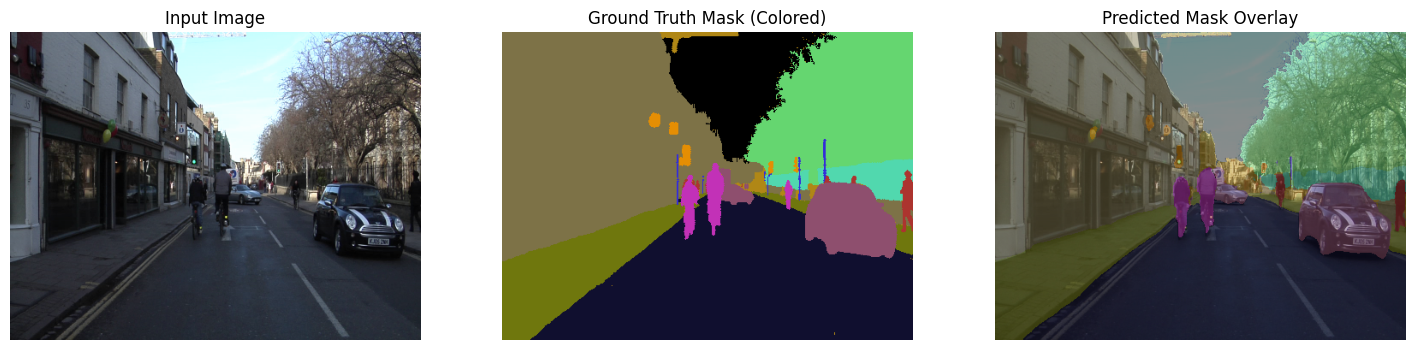

In [54]:
visualize_overlay(best_model, test_loader, class_colors, num_samples=3)
